In [1]:
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as K
import os

cwd = os.getcwd()

savefig = os.path.join(cwd, 'Images')

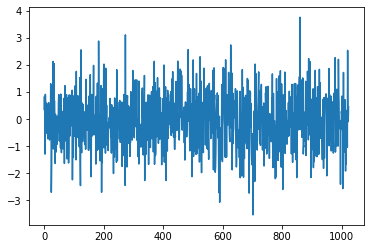

In [2]:
N = 1024
x = (2*np.pi*np.arange(1,N+1)/N)
rng = default_rng(1)
u = rng.standard_normal(N).astype('float128')
v = fft(u)
nu = 0.05

u_0 = u
plt.figure(facecolor="white")
plt.plot(u_0)

# spatial grid and initial conditions
h = 0.01
k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16).astype('float128')
L = k**2 - nu*k**4
exp1 = np.exp(h*L)
exp2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

tmax = 10
step_max = round(tmax/h)
step_plt = int(tmax/(1000*h))
g = -0.5j*k
# tt = np.zeros(step_max)
# uu = np.zeros((N,step_max))
uu = np.array([u])
tt = 0

for step in range(1, step_max):
    t = step*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = exp2*v + Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = exp2*v + Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = exp2*a + Q*(2*Nb - Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if step % step_plt == 0:
        u = np.real(ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
        # uu[:,step] = u
        # tt[step] = t

In [3]:
# Queste "strane strutture" (f1,f2,f3) sono alla base dell'integrazione....
# plt.figure()
# plt.plot(f1)
# plt.plot(f2)
# plt.plot(f3)

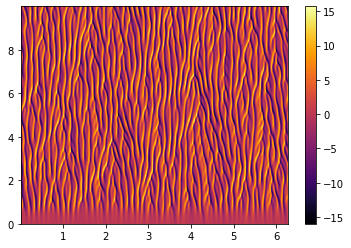

In [4]:
fig, ax = plt.subplots(1,1,)
X, T = np.meshgrid(x, tt)
im = ax.pcolormesh(X, T, uu, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()

In [5]:
# Here we do the training on the KS equations with the initial boundary conditions

# x_train = uu[:-1,:]
# y_train = uu[1:,:]

# # Autoencoder structure
# x_in = K.Input(shape=(1024,))
# y = K.layers.Dense(800, activation="relu")(x_in)
# y = K.layers.Dense(800, activation="relu")(y)
# y = K.layers.Dense(800, activation="relu")(y)
# y = K.layers.Dense(1024, activation="linear")(y)
# model = K.Model(x_in, y)

# model.compile(
#     optimizer="adam",
#     loss="mean_absolute_error",
#     metrics=None,
# )

# # Train model on dataset
# train_history = model.fit(
#     x = x_train,
#     y = y_train,
#     shuffle=True,
#     epochs=1000,
#     verbose=2,
#     use_multiprocessing=True,
#     workers=8,
# )

# model.save(os.path.join("KS_model_new"))



In [6]:
NN = K.models.load_model(os.path.join(cwd,"KS_model_new"))
dt = h # time interval
n_t = np.around(tmax/dt)
steps = np.arange(0,n_t).astype(int)
u_nn = np.zeros((int(n_t), N))

# Saving the initial conditions in N
u_nn[0,:] = u_0

for step in steps[:-1]:

    pred = NN.predict(u_nn[step,:].reshape(1,1024))
    u_nn[step+1,:] = pred
        

2022-07-15 22:02:44.616037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 22:02:44.625848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 22:02:44.626329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 22:02:44.627346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1/1 [==============================] - 0s 21ms/step


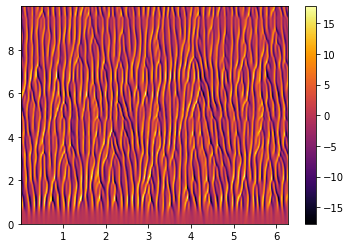

In [7]:
fig, ax = plt.subplots(1,1)
t = steps*dt
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, u_nn, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()

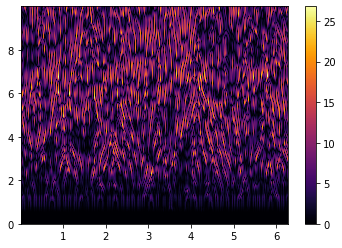

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [8]:
# Qua devo confontare la predizione con il modello originale in training

def picture_abs_error(real,neural,x,y):
    
    assert isinstance(real, np.ndarray) and isinstance(neural, np.ndarray)
    assert real.shape == neural.shape

    error = np.abs(real-neural)
    fig, ax = plt.subplots(1,1)
    t = steps*dt
    X, T = np.meshgrid(x, t)
    im = ax.pcolormesh(X, T, error, cmap='inferno', rasterized=True)
    fig.colorbar(im)
    plt.show()

    return error
    
err = picture_abs_error(uu,u_nn,x,t)
plt.savefig


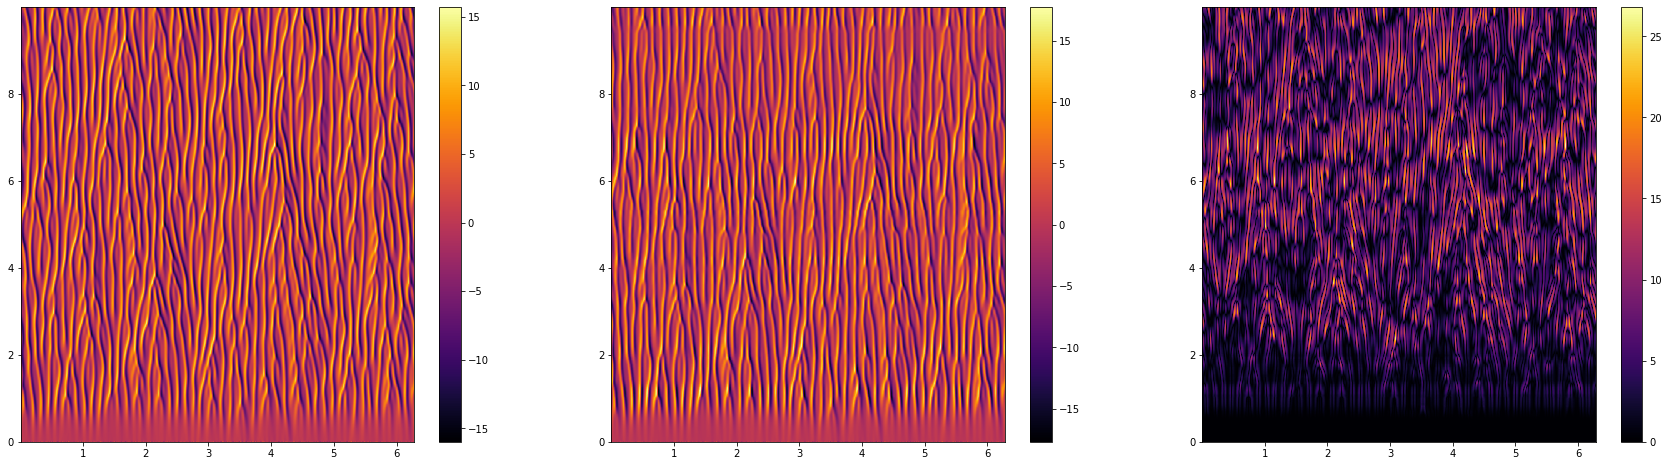

In [9]:
# All in a single plot

# Original
plt.figure(figsize=(30, 8), facecolor='white')
ax = plt.subplot(1, 3, 1)
X, T = np.meshgrid(x, tt)
im = ax.pcolormesh(X, T, uu, cmap='inferno', rasterized=True)
plt.colorbar(im)

# Neural network prediction
ax = plt.subplot(1, 3, 2)
t = steps*dt
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, u_nn, cmap='inferno', rasterized=True)
plt.colorbar(im)

# error
ax = plt.subplot(1, 3, 3)
t = steps*dt
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, err, cmap='inferno', rasterized=True)
plt.colorbar(im)

plt.savefig(os.path.join(savefig, "KS_train"))
plt.show()

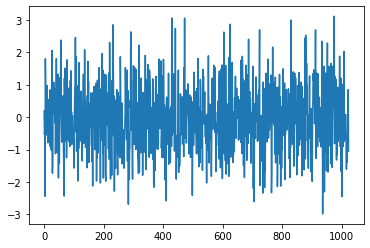

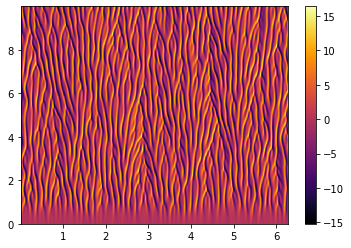

In [10]:
# Qua devo compararlo con condizioni iniziali totalmente differenti

# NEW INITIAL CONDITIONS

N = 1024
x = (2*np.pi*np.arange(1,N+1)/N)
rng = default_rng(2)

u = rng.standard_normal(N).astype('float128')
#u = np.sin(np.linspace(-2*np.pi, +2*np.pi, N)) + 0.5*rng.standard_normal(N)
v = fft(u)
nu = 0.05

u_0 = u
plt.figure(facecolor="white")
plt.plot(u_0)

# spatial grid and initial conditions
h = 0.01
k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16).astype('float128')
L = k**2 - nu*k**4
exp1 = np.exp(h*L)
exp2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

tmax = 10
step_max = round(tmax/h)
step_plt = int(tmax/(1000*h))
g = -0.5j*k
# tt = np.zeros(step_max)
# uu = np.zeros((N,step_max))
uu = np.array([u])
tt = 0

for step in range(1, step_max):
    t = step*h
    Nv = g*fft(np.real(ifft(v))**2)
    a = exp2*v + Q*Nv
    Na = g*fft(np.real(ifft(a))**2)
    b = exp2*v + Q*Na
    Nb = g*fft(np.real(ifft(b))**2)
    c = exp2*a + Q*(2*Nb - Nv)
    Nc = g*fft(np.real(ifft(c))**2)
    v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if step % step_plt == 0:
        u = np.real(ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
        # uu[:,step] = u
        # tt[step] = t

fig, ax = plt.subplots(1,1,)
X, T = np.meshgrid(x, tt)
im = ax.pcolormesh(X, T, uu, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()

In [11]:
# ...Comparing with the result of the NN trained in the other set

NN = K.models.load_model(os.path.join(cwd,"KS_model_new"))
dt = h # time interval
n_t = np.around(tmax/dt)
steps = np.arange(0,n_t).astype(int)
u_nn = np.zeros((int(n_t), N))

# Saving the initial conditions in N
u_nn[0,:] = u_0

for step in steps[:-1]:

    pred = NN.predict(u_nn[step,:].reshape(1,1024))
    u_nn[step+1,:] = pred

1/1 [==============================] - 0s 14ms/step


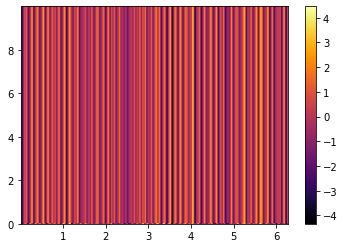

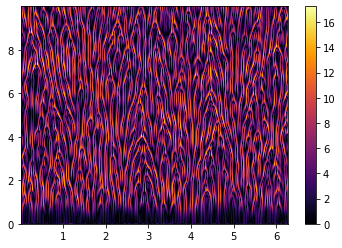

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.94648432, 0.88620448, 0.0543099 , ..., 0.32378044, 0.58929449,
        1.09832704],
       [0.96049081, 0.86624164, 0.41606532, ..., 1.0770552 , 0.97013474,
        1.09901007],
       ...,
       [0.77003021, 2.41729178, 4.65794218, ..., 1.64353967, 1.07233405,
        0.50044246],
       [0.75353585, 2.42216657, 4.67695924, ..., 1.69627856, 1.12660868,
        0.53940692],
       [0.72368341, 2.41371404, 4.68335122, ..., 1.76199109, 1.19400591,
        0.59159898]], dtype=float128)

In [12]:
fig, ax = plt.subplots(1,1)
t = steps*dt
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, u_nn, cmap='inferno', rasterized=True)
fig.colorbar(im)
plt.show()

picture_abs_error(uu,u_nn,x,t)

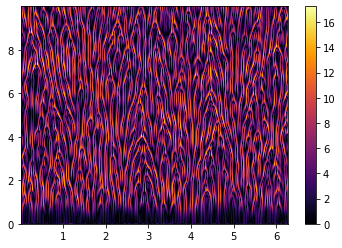

<function matplotlib.pyplot.savefig(*args, **kwargs)>

In [13]:
# Qua devo confontare la predizione con il modello originale in training

def picture_abs_error(real,neural,x,y):
    
    assert isinstance(real, np.ndarray) and isinstance(neural, np.ndarray)
    assert real.shape == neural.shape

    error = np.abs(real-neural)
    fig, ax = plt.subplots(1,1)
    t = steps*dt
    X, T = np.meshgrid(x, t)
    im = ax.pcolormesh(X, T, error, cmap='inferno', rasterized=True)
    fig.colorbar(im)
    plt.show()

    return error
    
err = picture_abs_error(uu,u_nn,x,t)
plt.savefig

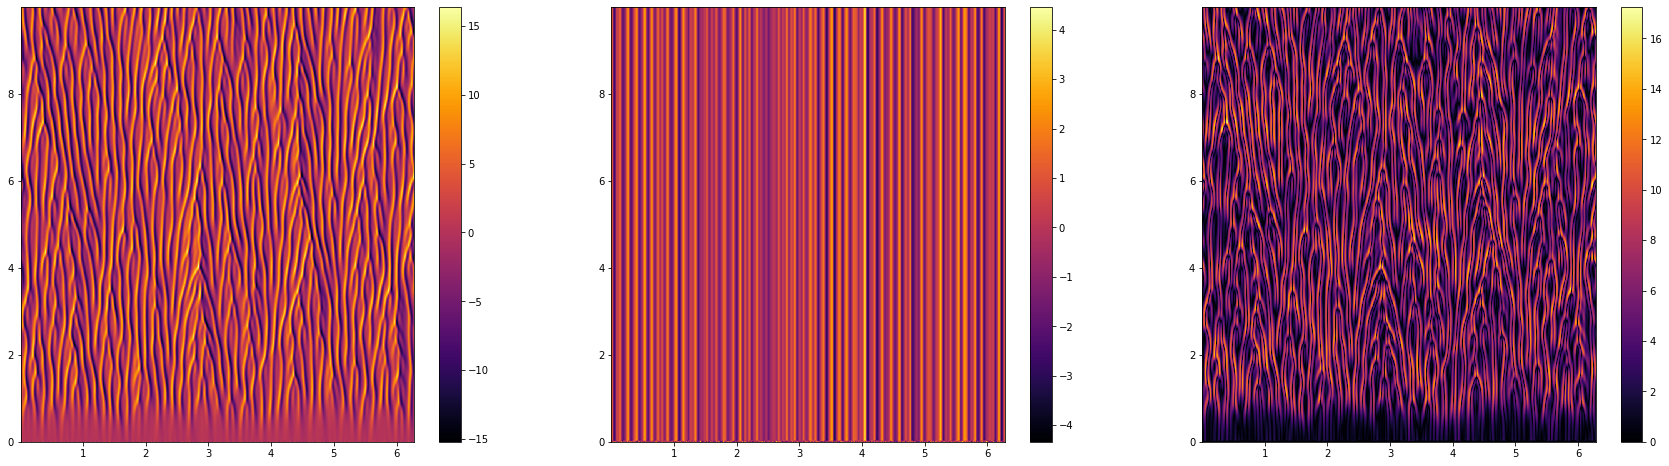

In [14]:
# All in a single plot

# Original
plt.figure(figsize=(30, 8), facecolor='white')
ax = plt.subplot(1, 3, 1)
X, T = np.meshgrid(x, tt)
im = ax.pcolormesh(X, T, uu, cmap='inferno', rasterized=True)
plt.colorbar(im)

# Neural network prediction
ax = plt.subplot(1, 3, 2)
t = steps*dt
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, u_nn, cmap='inferno', rasterized=True)
plt.colorbar(im)

# error
ax = plt.subplot(1, 3, 3)
t = steps*dt
X, T = np.meshgrid(x, t)
im = ax.pcolormesh(X, T, err, cmap='inferno', rasterized=True)
plt.colorbar(im)

plt.savefig(os.path.join(savefig, "KS_test"))
plt.show()